In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Anomaly detection(사기감지 데이터) 로드
data = pd.read_csv('/content/drive/My Drive/creditcard.csv')
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

In [6]:
# target 데이터 확인
data['Class'].value_counts()

0    284314
1       492
Name: Class, dtype: int64

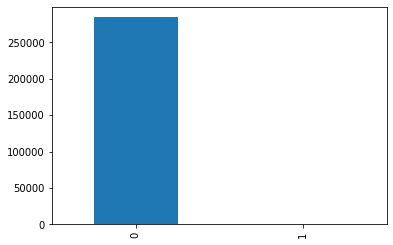

In [7]:
# target 데이터 분포
data['Class'].value_counts().plot(kind='bar')

target 데이터가 불균형하므로 향후 undersampling을 진행하도록 합니다. 

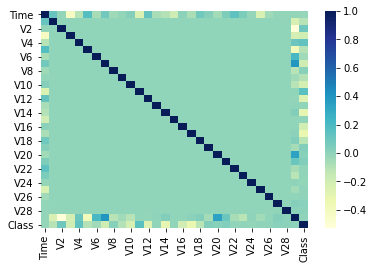

In [8]:
# target과의 상관관계
sns.heatmap(data.corr(), cmap='YlGnBu')

Text(0.5, 1.0, 'V17 boxplot')

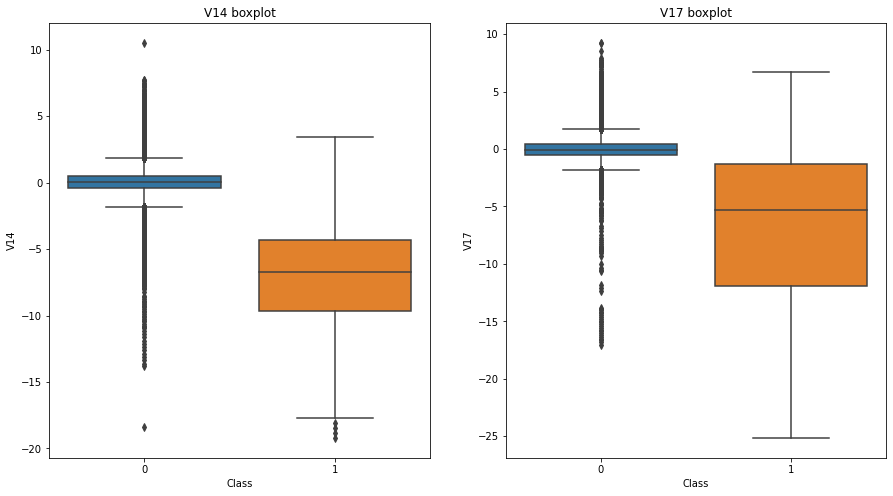

In [9]:
# target과 상관관계가 높아보이는 V14, V17 변수 boxplot
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.boxplot(x='Class', y='V14', data=data, ax=axes[0])
axes[0].set_title('V14 boxplot')

sns.boxplot(x='Class', y='V17', data=data, ax=axes[1])
axes[1].set_title('V17 boxplot')

Class 0과 1이 각 변수에 따라 서로 다른 분포를 보여주고 있으므로, 해당 변수를 주요 변수로 상정한 후 이상치를 제거해줍니다.

In [10]:
# Class가 0인 경우에 한해서 이상치 제거
def remove_outlier(data, col):
  fraud_col = data[data['Class']==0][col]
  q25 = np.percentile(fraud_col.values, 25)
  q75 = np.percentile(fraud_col.values, 75)

  iqr = (q75 - q25) * 1.5
  lowest = q25-iqr
  highest = q75+iqr
  outlier = fraud_col[(fraud_col < lowest)|(fraud_col > highest)].index
  print(len(outlier))
  data.drop(outlier, axis=0, inplace=True)
  print(data.shape)
  return data

removed_data = remove_outlier(data, 'V14')
removed_data = remove_outlier(removed_data, 'V17')

13800
(271006, 31)
3578
(267428, 31)


In [11]:
# whole dataset 분리
X_train, X_test, y_train, y_test = train_test_split(removed_data.iloc[:,:-1], removed_data.iloc[:,-1], test_size=0.2, random_state=0)

# scaling
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [12]:
# undersampling (majority class instances를 제거하는 방법)

# target 데이터 수 
number_fraud = len(removed_data[removed_data['Class']==1])

fraud_indices = np.array(removed_data[removed_data['Class']==1].index)
normal_indices = removed_data[removed_data['Class']==0].index

# 정상 데이터셋에서 사기 데이터 수만큼 랜덤 선택
random_normal_indices = np.random.choice(normal_indices, number_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# 사기 데이터 인덱스와 랜덤으로 추출한 인덱스 연결
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# under sample dataset
under_sample_data = removed_data.loc[under_sample_indices, :]

X_undersample = under_sample_data.iloc[:, :-1]
y_undersample = under_sample_data.iloc[:, -1]

print('정상 데이터 비율 : ', len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print('사기 데이터 비율 : ', len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print('전체 데이터 수 : ', len(under_sample_data))

# undersampled dataset train-test 분리
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.2, random_state=0)

print('')
print('train dataset: ', len(X_train_undersample))
print('test dataset: ', len(X_test_undersample))
print('Total dataset: ', len(X_train_undersample)+len(X_test_undersample))



정상 데이터 비율 :  0.5
사기 데이터 비율 :  0.5
전체 데이터 수 :  984

train dataset:  787
test dataset:  197
Total dataset:  984


In [13]:
# scaling
scaler = StandardScaler()
scaled_X_train_undersample = pd.DataFrame(scaler.fit_transform(X_train_undersample), columns=X_train_undersample.columns)
scaled_X_test_undersample = pd.DataFrame(scaler.transform(X_test_undersample), columns=X_test_undersample.columns)

In [14]:
# uncustomized model
svc = SVC(kernel='linear')
svc.fit(scaled_X_train_undersample, y_train_undersample)
y_pred = svc.predict(scaled_X_test_undersample)

In [15]:
print('Accuracy Score: ', metrics.accuracy_score(y_test_undersample, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test_undersample, y_pred))
print('Precision: ', metrics.precision_score(y_test_undersample, y_pred))
print('Recall: ', metrics.recall_score(y_test_undersample, y_pred))
print('F1: ', metrics.f1_score(y_test_undersample, y_pred))

Accuracy Score:  0.9695431472081218
Confusion matrix: 
 [[105   1]
 [  5  86]]
Precision:  0.9885057471264368
Recall:  0.945054945054945
F1:  0.9662921348314606


In [16]:
# GridSearchCV 이용한 model
svm_model = SVC()
tuned_parameters = {
    'C' : [10**c for c in range(-2,2)],
    'gamma' : [10**gamma for gamma in range(-2,2)],
    'kernel' : ['linear', 'rbf']
}

grid_svm = GridSearchCV(svm_model, tuned_parameters, scoring='accuracy', n_jobs=-1)
grid_svm.fit(scaled_X_train_undersample, y_train_undersample)
y_pred_grid = grid_svm.predict(scaled_X_test_undersample)

In [17]:
print('best model: \n', grid_svm.best_estimator_)
print('\nbest parameter: \n', grid_svm.best_params_)
print('\nbest score: \n', grid_svm.best_score_.round(3))

best model: 
 SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

best parameter: 
 {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

best score: 
 0.942


In [18]:
print('Accuracy Score: ', metrics.accuracy_score(y_test_undersample, y_pred_grid))
print('Confusion matrix: \n', confusion_matrix(y_test_undersample, y_pred_grid))
print('Precision: ', metrics.precision_score(y_test_undersample, y_pred_grid))
print('Recall: ', metrics.recall_score(y_test_undersample, y_pred_grid))
print('F1: ', metrics.f1_score(y_test_undersample, y_pred_grid))

Accuracy Score:  0.9695431472081218
Confusion matrix: 
 [[105   1]
 [  5  86]]
Precision:  0.9885057471264368
Recall:  0.945054945054945
F1:  0.9662921348314606


In [23]:
# 최종 모델을 whole dataset에 적용
final_model = SVC(C=1, gamma=0.01, kernel='linear')
final_model.fit(X_train_undersample, y_train_undersample)

Y_pred = final_model.predict(scaled_X_test)

print('Accuracy Score: ', metrics.accuracy_score(y_test, Y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, Y_pred))
print('Precision: ', metrics.precision_score(y_test, Y_pred))
print('Recall: ', metrics.recall_score(y_test, Y_pred))
print('F1: ', metrics.f1_score(y_test, Y_pred))

Accuracy Score:  0.8660584078076506
Confusion matrix: 
 [[46230  7163]
 [    1    92]]
Precision:  0.012680909717436252
Recall:  0.989247311827957
F1:  0.025040827436037017


cf.) undersampling 하지 않은 dataset으로 SVM 수행한 결과 

In [21]:
# uncustomized model
svc = SVC(kernel='linear')
svc.fit(scaled_X_train, y_train)
y_pred = svc.predict(scaled_X_test)

In [22]:
print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))

Accuracy Score:  0.9997569457428112
Confusion matrix: 
 [[53393     0]
 [   13    80]]
Precision:  1.0
Recall:  0.8602150537634409
F1:  0.9248554913294798


정리: 
- imbalanced dataset의 경우, 정확도보다는 실제 사기를 예측하는 것이 더 중요하므로 Recall 지표를 중심으로 살펴보면, undersampling을 한 SVM 모델이 더 성능이 좋았습니다. 
- 또한 creditcard와 같이 데이터 양이 많은 경우 한 번 학습할 때 시간이 오래 걸리므로, 시간적인 효율성을 고려하면 undersampling을 적용하면서 parameter tuning을 하는 것이 더 좋을 것 같습니다.  
- 그러나 undersample dataset만으로 modeling한 결과와 whole dataset으로 modeling한 결과가 false positive 측면에서 차이가 많이 났었는데, 사기예측을 엄격하게 할것인지, 아니면 사기예측 비용을 절감할 것인지 등의 사용자의 관점에 따라 undersampling 적용여부가 달라질 것 같습니다. 